# Mary Catharine McKeithen - Final Project
Fomula One (or F1) is a form of autoracing that has exploded in popularity in recent years due to the Netflix show, Drive to Survive. Each year, drivers and constructors (companies that build the racecars) compete in a series of races called Grand Prix to win points. At the end of the season, the driver and constructor with the most points are each awarded a World Championship, which, along with fame and renown, confers financial and technical benefits for the next year.

In [1]:
library('tidyverse')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
Warning message:
“package ‘stringr’ was built under R version 4.2.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
f1 = read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-09-07/results.csv')
drivers = read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-09-07/drivers.csv')
constructors = read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-09-07/constructors.csv')
races = read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-09-07/races.csv')
status = read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-09-07/status.csv')

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 25220 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): position, positionText, time, milliseconds, fastestLap, rank, fast...
dbl (10): resultId, raceId, driverId, constructorId, number, grid, positionO...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 853 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (7): driverRef, number, code, forename, surname, nationality, url
dbl  (1): driverId
date (1): dob

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 211 Columns: 5
── Column specification ─────

In [3]:
f1_results = f1 |>
    rename(driver_num = number, finish_time = time) |>
    left_join(y = drivers, by = 'driverId') |>
    rename(driver_nationality = nationality) |>
    left_join(y = constructors, by = 'constructorId') |>
    rename(constructor_nationality = nationality, constructor = name) |>
    left_join(races, by = "raceId") |>
    rename(race = name, start_time = time) |>
    left_join(status, by = "statusId") |>
    select(-c(url.x, url.y, url)) |>
    filter(year > 2013) |>
    mutate(constructor = ifelse(constructor == 'Toro Rosso', 'AlphaTauri', constructor)) |>
    mutate(constructor = ifelse(constructor == 'Renault' | constructor == 'Lotus F1', 'Alpine F1 Team', constructor)) |>
    mutate(constructor = ifelse(constructor == 'Sauber', 'Alfa Romeo', constructor)) |>
    mutate(constructor = ifelse(constructor == 'Racing Point' | constructor == 'Force India', 'Aston Martin', constructor))
# colnames(f1_results)

In [4]:
colors <- c("red", "blue3", "dark green", "gold", "orange", "navy", 'cornflowerblue', 'darkturquoise', 'hotpink', 'firebrick') 
names(colors) <- c('Ferrari', 'Red Bull', 'Aston Martin', 'Alfa Romeo', 'McLaren', 'AlphaTauri', 'Williams', 'Mercedes', 'Alpine F1 Team', 'Haas F1 Team')

In 2014, F1 significantly changed the design of the cars and switched to using hybrid engines. During this time, Mercedes has been the dominant constructor, winning eight constructors championships between 2014 and 2021. Red Bull and Ferrari were competitive with Mercedes, while the other constructors with less funding and fewer resources competed for the "best of the rest".

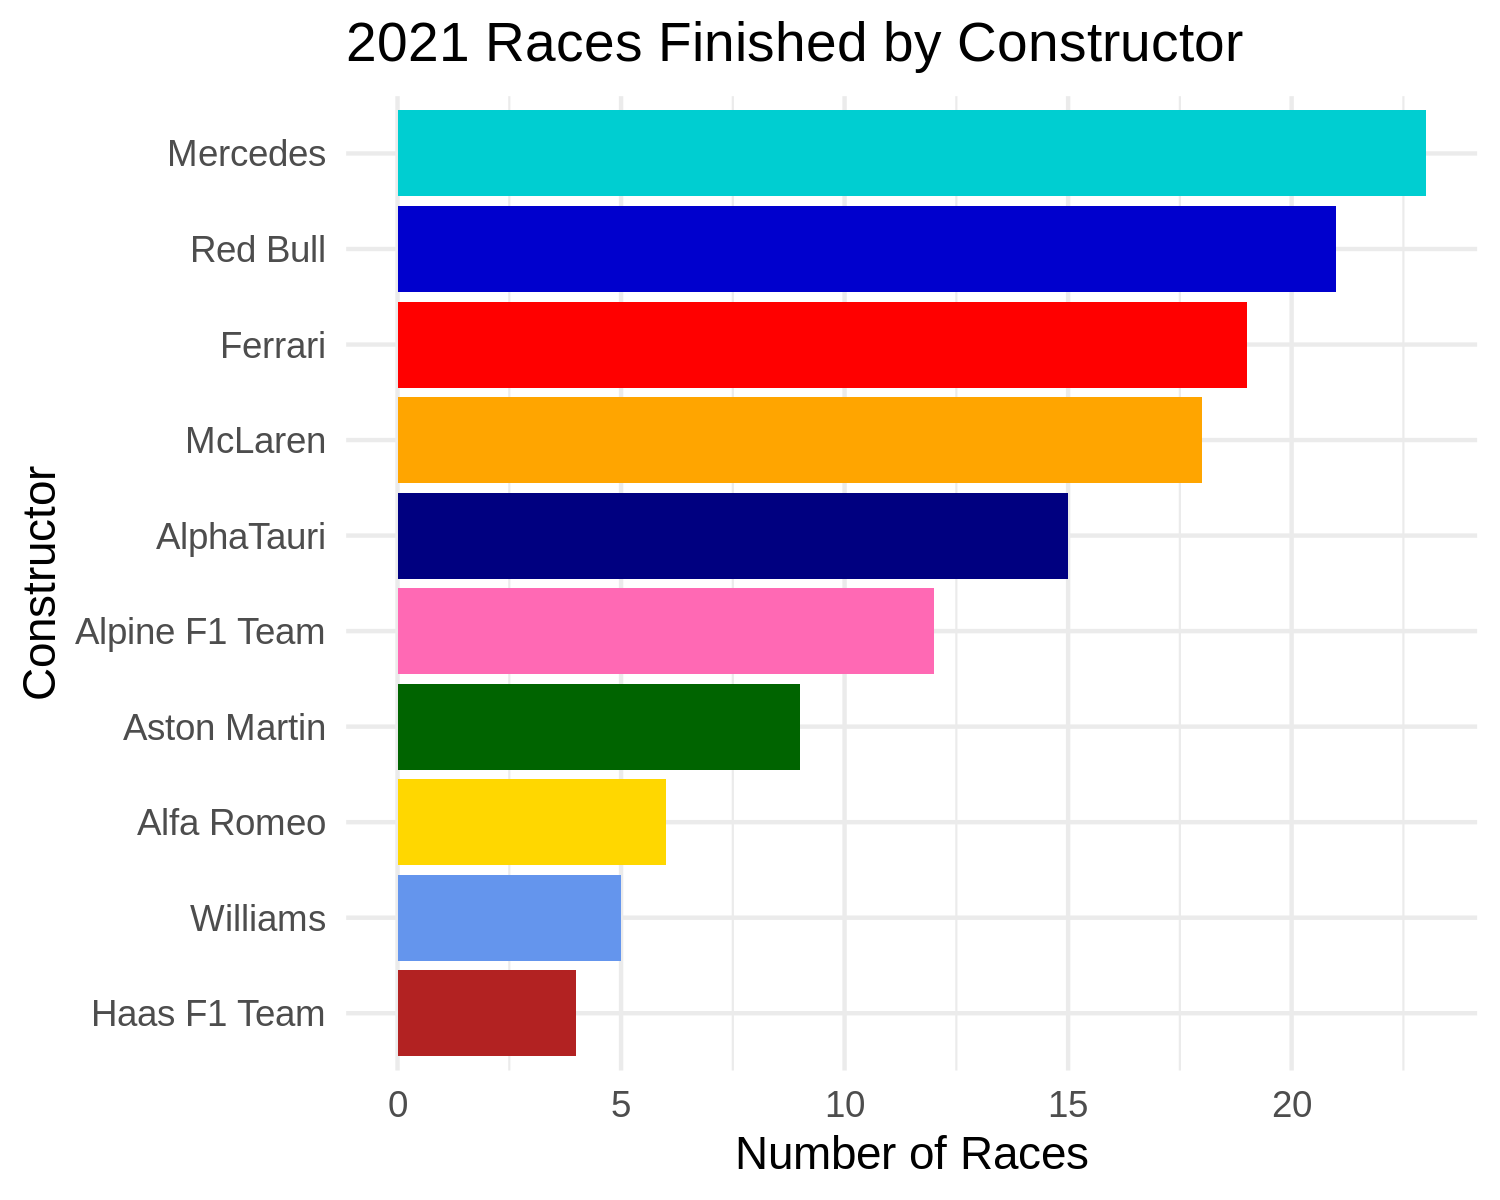

In [5]:
dnf = f1_results |>
    filter(status == 'Finished' & year == 2021) |>
    group_by(constructor) |>
    summarize(num_finish = n(), .groups = 'drop') |>
    arrange(num_finish) |>
    mutate(constructor = fct_inorder(constructor))

p3 = ggplot(dnf, aes(y = constructor, x = num_finish, fill = constructor)) + 
    geom_col() +
    theme_minimal() + 
    labs(y = 'Constructor', title = '2021 Races Finished by Constructor', x = 'Number of Races') +
    scale_fill_manual(values = colors) +
    theme(legend.position = "none")

p3

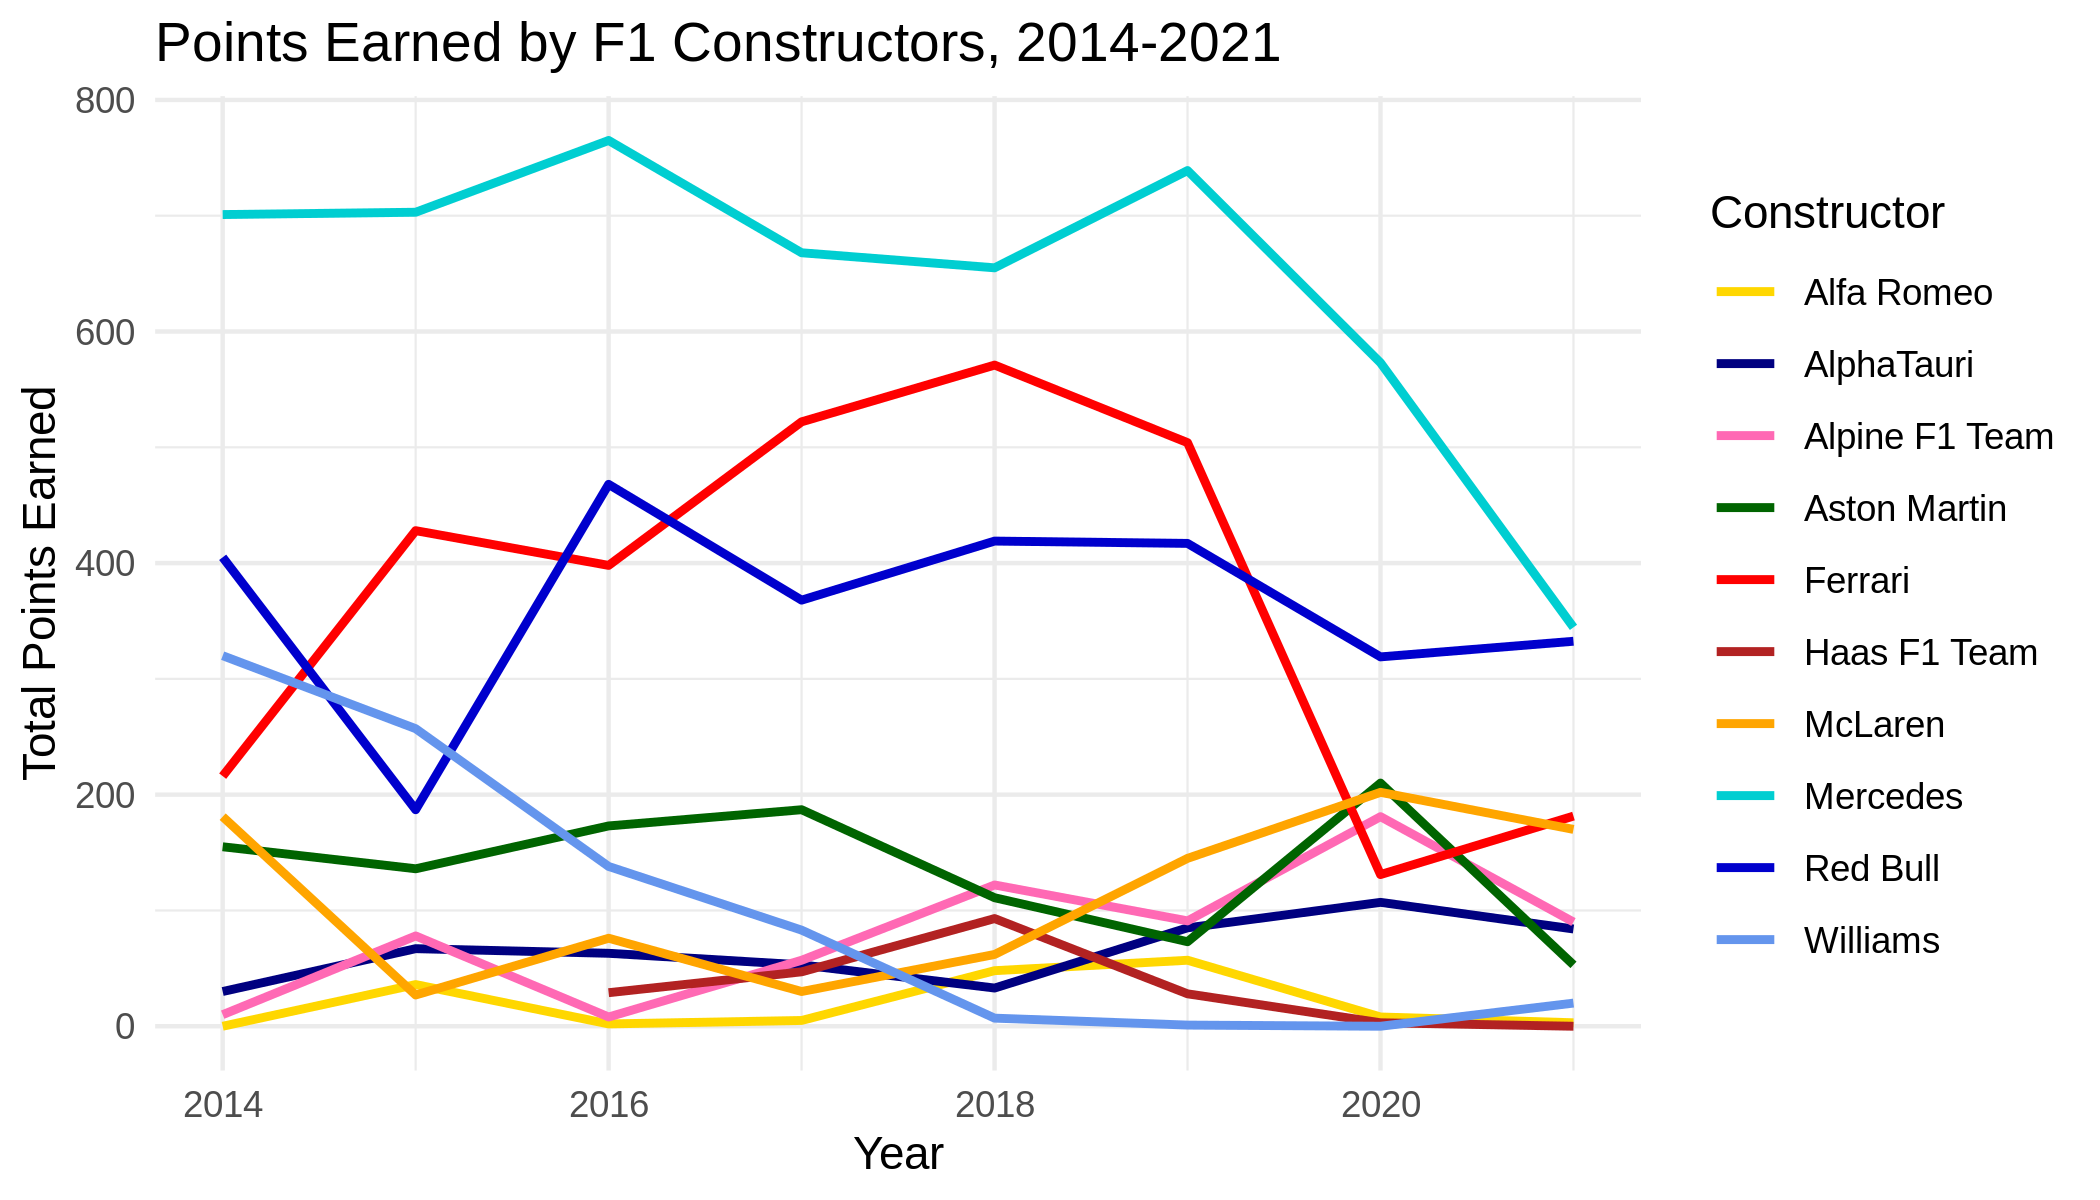

In [6]:
options(repr.plot.width = 7, repr.plot.height = 4, repr.plot.res = 300)

const_pts = f1_results |> 
    group_by(constructor) |>
    filter(sum(points) > 100) |> #Lotus only competed 2014-2015
    ungroup() |>
    group_by(year, constructor) |>
    summarize(total_pts = sum(points), .groups = 'drop')


p = ggplot(const_pts, aes(x = year, y = total_pts, color = constructor)) + 
    geom_line(linewidth = 1) +
    theme_minimal() +
    labs(x = 'Year', y = 'Total Points Earned', color = 'Constructor', title = 'Points Earned by F1 Constructors, 2014-2021') + 
    scale_color_manual(values = colors)

p

In F1, each constructor has two cars and hires two drivers to race for points. During the hybrid era, Lewis Hamilton, a driver for Mercedes, has won seven World Driver Championships, only being beaten by his teammate, Nico Rosberg, in 2016. In F1, drivers are free agents and frequently switch constuctor teams over the course of their career based on seat availability and contract negotiations. The below graph shows points earned by drivers during the hybrid era and what constructor they were racing for at the time.

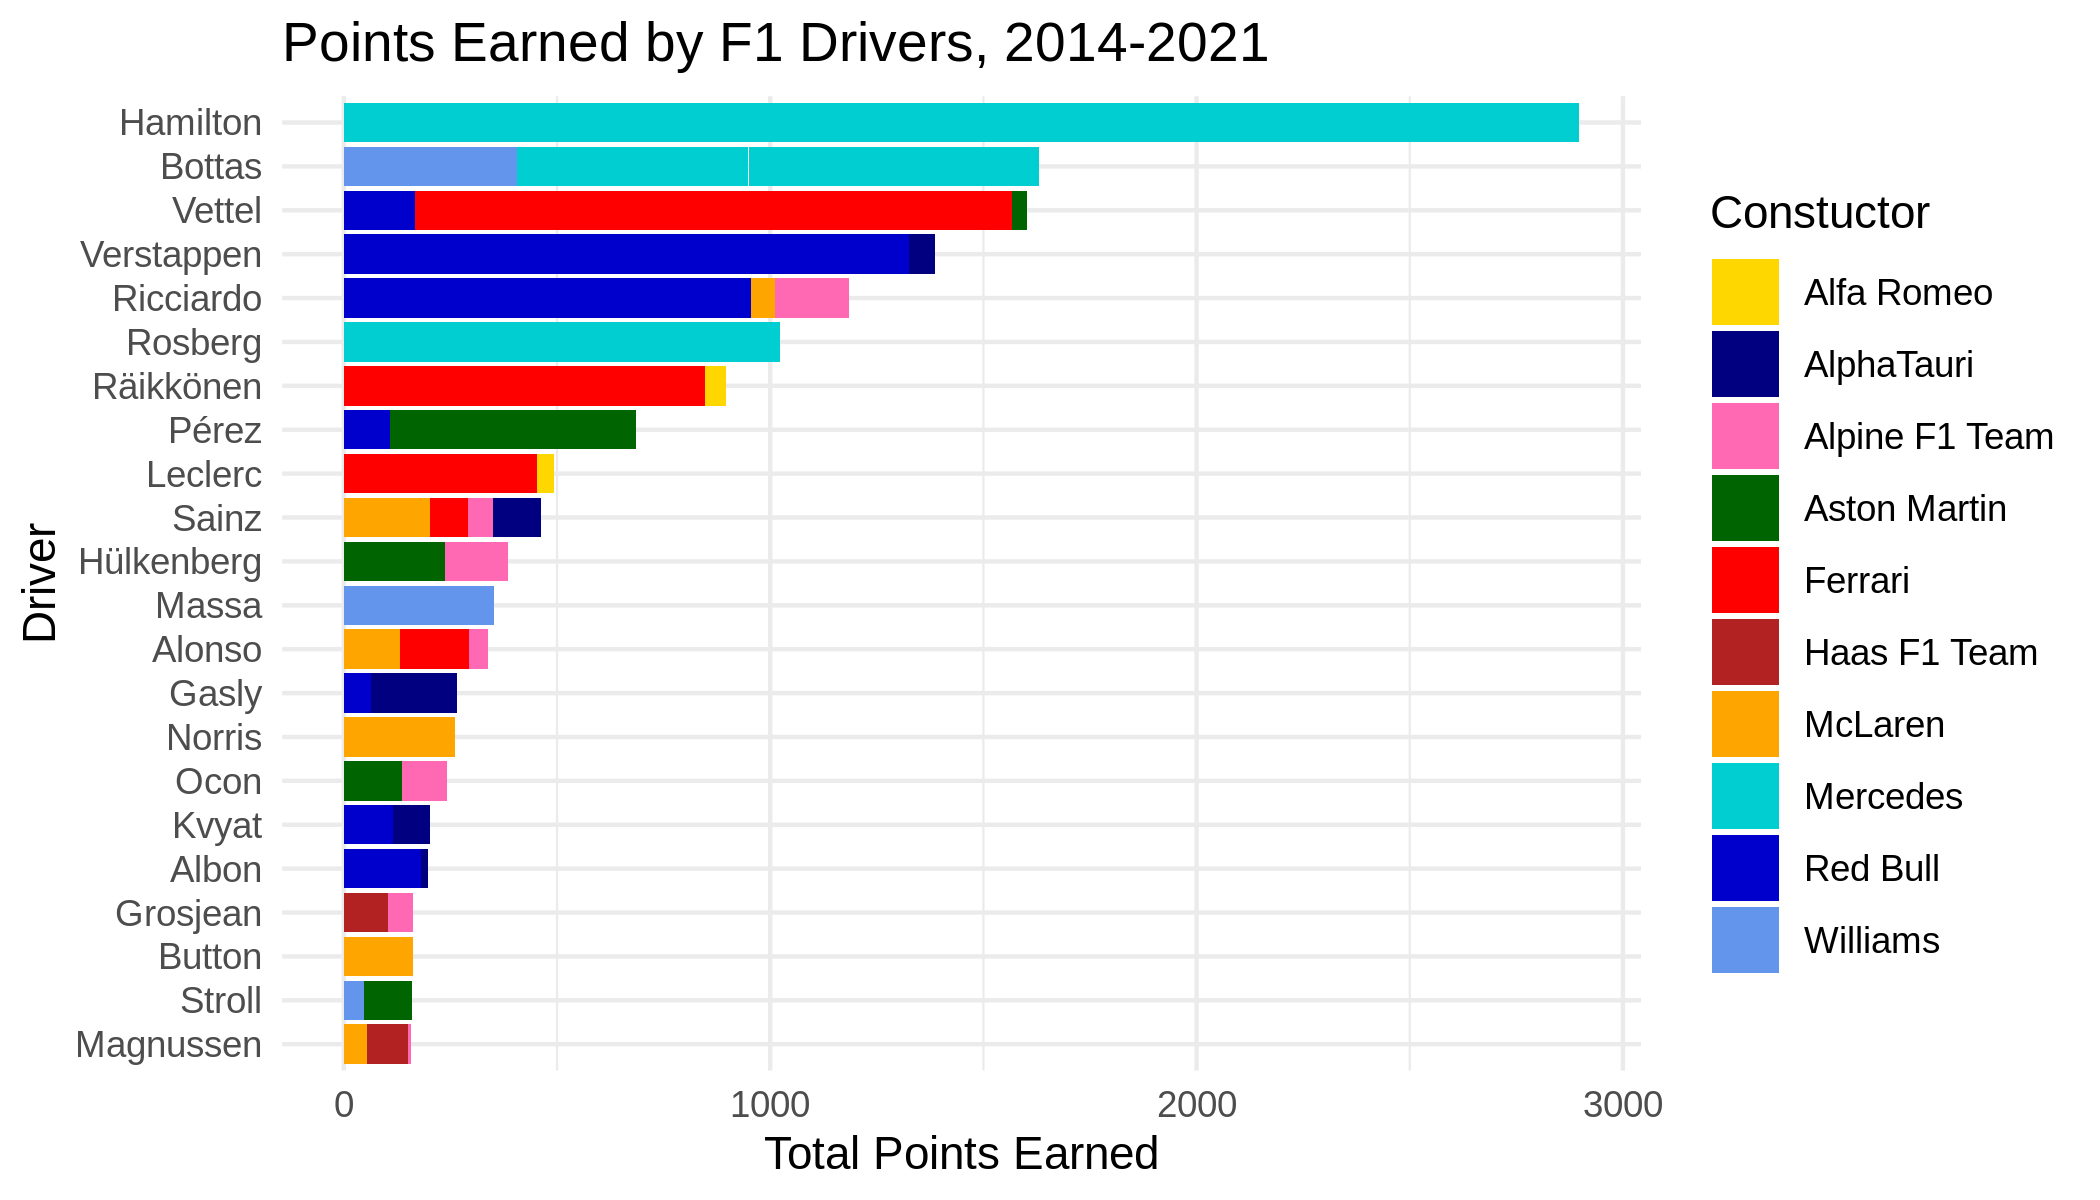

In [7]:
driver_pts = f1_results |>
    group_by(surname) |>
    summarize(total_pts = sum(points), constructor = constructor, points = points, .groups = 'drop') |>
    arrange(total_pts) |>
    filter(total_pts > 50) |>
    mutate(surname = fct_inorder(surname))

p1 = ggplot(driver_pts, aes(y = surname, x = points, fill = constructor)) + 
    geom_col(na.rm = TRUE) +
    theme_minimal() + 
    labs(y = 'Driver', x = 'Total Points Earned', 
         title = 'Points Earned by F1 Drivers, 2014-2021',
        fill = 'Constuctor') +
    scale_fill_manual(values = colors)
p1

Each Grand Prix weekend, drivers try to set the fastest lap in qualifying on Saturday in order to have the best starting position for the race on Sunday. Points are awarded to drivers that finish places 1-10 in decreasing amounts. As a result, drivers are constantly fighting to "move up the grid" so they and their constructors can earn more points. The graph below shows the starting and ending positions for drivers for the 2021 Monaco Grand Prix, one of the most well-known F1 circuits. Charles LeClerc, racing for Ferrari, qualified first but failed to finish the race due to a mechanical issues. Max Verstappen, racing for Red Bull, won the race.

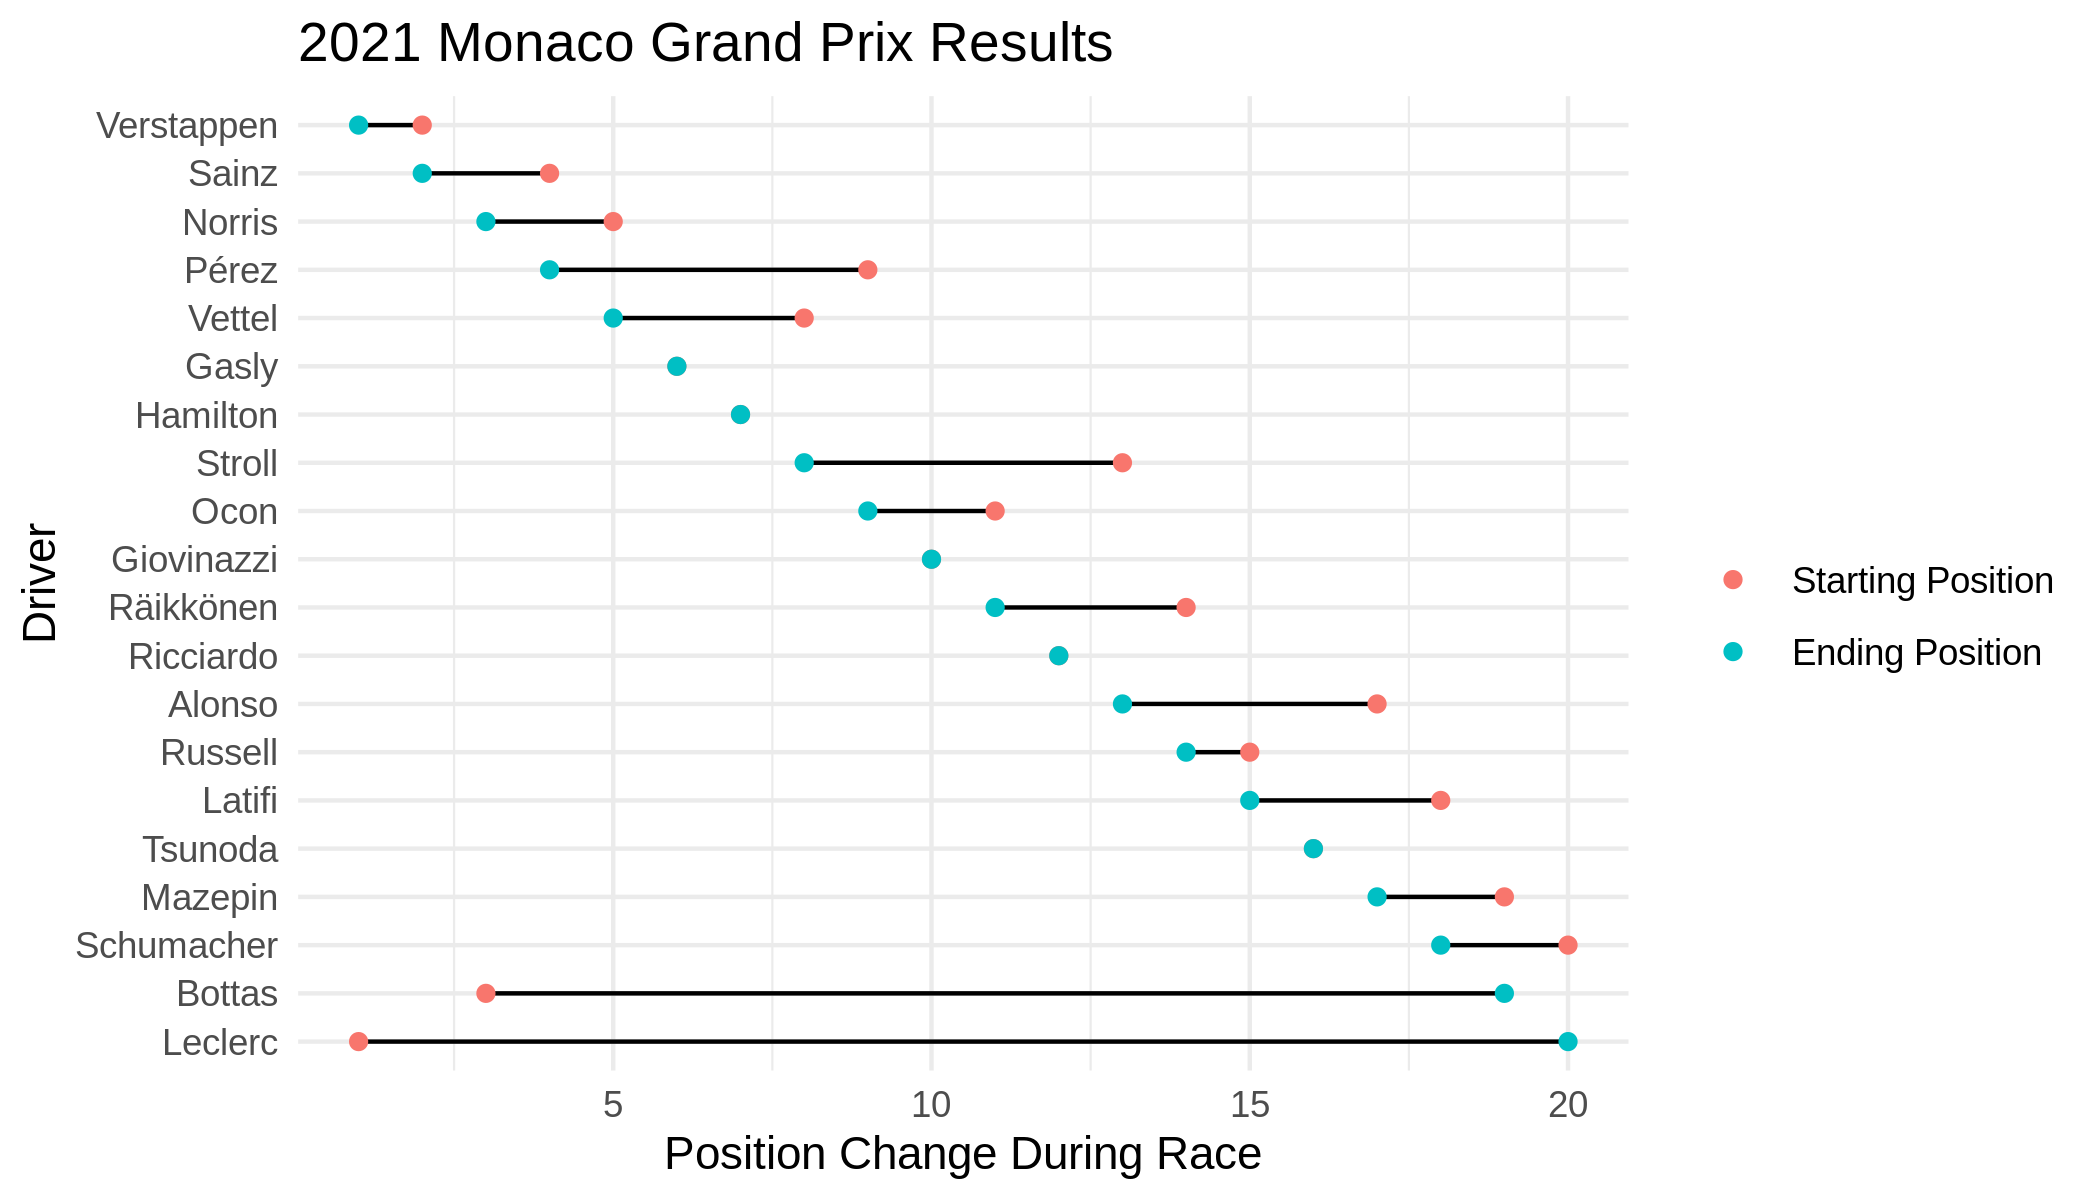

In [8]:
position = f1_results |>
    filter(year == 2021 & race == 'Monaco Grand Prix') |>
    group_by(surname) |>
    summarize(grid, positionOrder) |>
    arrange(desc(positionOrder)) |>
    mutate(surname = fct_inorder(surname))

position_long = position |>
    pivot_longer(cols = c(grid, positionOrder))

# head(position_long)

p4 = ggplot(position_long, aes(x = value, y = surname)) + 
    geom_segment(data = position, 
                 mapping = aes(y = surname, yend = surname, x = positionOrder, xend = grid)) +
    geom_point(aes(color = name)) +
    labs(x = 'Position Change During Race', y = 'Driver', title = '2021 Monaco Grand Prix Results', color = '') +
    theme_minimal() +
    scale_color_discrete(labels=c('Starting Position', 'Ending Position'))

p4